In [3]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [4]:
import sys
import pandas as pd
sys.path.append('../../param_search')
import param_search as ps

In [ ]:
# define a job template and name format
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -x v034
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project
nvidia-smi

data_root=../../../data/{data_name}

case_name=Case{case_id:d}{case_suffix}
case_dir=$data_root/$case_name

image_dir=$case_dir/NIFTI
mask_dir=$case_dir/TotalSegment

image_name=case{case_id:d}_T{phase:02d}
image_file=$image_dir/$image_name.nii.gz
output_dir=$mask_dir/$image_name

TotalSegmentator -i $image_file -o $output_dir -d gpu -ta total --roi_subset lung_upper_lobe_right lung_upper_lobe_left lung_middle_lobe_right lung_lower_lobe_right lung_lower_lobe_left
TotalSegmentator -i $image_file -o $output_dir -d gpu -ta lung_vessels
TotalSegmentator -i $image_file -o $output_dir -d gpu -ta body
totalseg_combine_masks -i $output_dir -o $output_dir/lung_combined_mask.nii.gz -m lung

echo Done
'''
name_format = 'segment_{data_name}_case{case_id:d}_T{phase:02d}'

In [ ]:
param_space = []
for p in ps.ParamSpace(
    data_name='Emory-4DCT',
    case_id=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    phase=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
):
    if p['case_id'] == 8:
        p['case_suffix'] = 'Deploy'
    else:
        p['case_suffix'] = 'Pack'
    param_space.append(p)

for p in param_space:
    print(name_format.format(**p))

In [ ]:
jobs = ps.submit(template, name_format, param_space, work_dir='2024-06-28_segment')
jobs

In [ ]:
status = ps.status(jobs)
status

In [ ]:
print(status.stdout.iloc[-10])

## Segmentation in notebook

In [1]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'
import torch
sys.path.append('..')
import project

torch.cuda.is_available()

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv002
--------------------------------------------------------------------------


True

In [5]:
%autoreload
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT', case_names=['Case1Pack', 'Case2Pack'])
emory4dct.load_niftis()

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T10.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T20.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T30.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T40.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T50.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIF

In [6]:
emory4dct[0].mask_file(phase=50, roi='lung_combined_mask')

PosixPath('../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz')

<IPython.core.display.Javascript object>


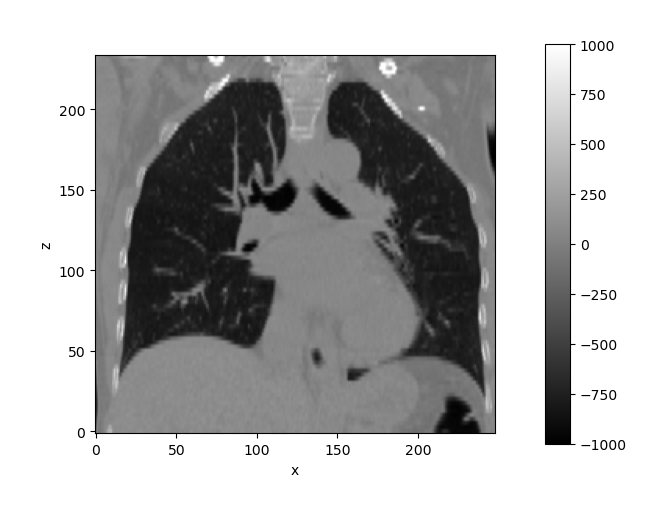

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [7]:
project.visual.view(emory4dct[0].array, x='x', y='z')

In [13]:
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator
from totalsegmentator.libs import combine_masks
help(totalsegmentator)

Help on function totalsegmentator in module totalsegmentator.python_api:

totalsegmentator(input: Union[str, pathlib.Path, nibabel.nifti1.Nifti1Image], output: Union[str, pathlib.Path, NoneType], ml=False, nr_thr_resamp=1, nr_thr_saving=6, fast=False, nora_tag='None', preview=False, task='total', roi_subset=None, statistics=False, radiomics=False, crop_path=None, body_seg=False, force_split=False, output_type='nifti', quiet=False, verbose=False, test=0, skip_saving=False, device='gpu', license_number=None, statistics_exclude_masks_at_border=True, no_derived_masks=False, v1_order=False, fastest=False, roi_subset_robust=None)
    Run TotalSegmentator from within python.
    
    For explanation of the arguments see description of command line
    arguments in bin/TotalSegmentator.
    
    Return: multilabel Nifti1Image



In [ ]:
%%time
for case in emory4dct.cases:
    for phase in emory4dct.phases:
        print(case, phase)
        
        image_file = emory4dct[0].nifti_file(phase=phase)
        mask_file = emory4dct[0].mask_file(phase=phase, roi='lung_combined_mask')
        mask_dir = mask_file.parent
        
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='total',
            roi_subset=[
                'lung_upper_lobe_right',
                'lung_middle_lobe_right',
                'lung_lower_lobe_right',
                'lung_upper_lobe_left',
                'lung_lower_lobe_left'
            ],
        )
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='lung_vessels'
        )
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='body'
        )
        mask_nii = combine_masks(
            mask_dir=mask_dir,
            class_type='lung'
        )
        nib.save(mask_nii, emory4dct[0].mask_file(phase=0, roi='lung_combined_mask'))

Emory4DCTCase('../data/Emory-4DCT', 'Case1Pack', 10 phases) 0

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 102.08it/s]


  Predicted in 6.39s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 93)
Resampling...
  Resampled in 1.13s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 176.83it/s]


  Predicted in 7.61s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.43s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 96.65it/s]


  Predicted in 6.71s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 93)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.17it/s]


  Predicted in 18.76s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.35s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.56s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 32.90it/s]


  Predicted in 7.58s


100%|██████████| 1/1 [00:00<00:00, 17.55it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

Creating body_extremities.nii.gz
  Saved in 0.22s
Creating body.nii.gz
Creating skin.nii.gz
Emory4DCTCase('../data/Emory-4DCT', 'Case1Pack', 10 phases) 10

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.23s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 105.71it/s]


  Predicted in 6.43s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 93)
Resampling...
  Resampled in 1.13s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 167.17it/s]


  Predicted in 7.59s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.45s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 101.28it/s]


  Predicted in 6.40s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 93)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.22it/s]


  Predicted in 18.70s
Saving segmentations...
Creating lung_vessels.nii.gz

Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.37s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.57s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 33.29it/s]


  Predicted in 7.57s


100%|██████████| 1/1 [00:00<00:00, 17.67it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.24s
Creating body.nii.gz
Creating skin.nii.gz
Emory4DCTCase('../data/Emory-4DCT', 'Case1Pack', 10 phases) 20

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 80.67it/s]


  Predicted in 6.58s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.15s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 178.26it/s]


  Predicted in 7.71s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.53s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 83.33it/s]


  Predicted in 6.56s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.28it/s]


  Predicted in 18.85s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.37s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.56s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 8/8 [00:00<00:00, 32.72it/s]


  Predicted in 7.54s


100%|██████████| 1/1 [00:00<00:00, 17.59it/s]

Resampling...


Saving segmentations...
Creating body_trunc.nii.gz
Creating body_extremities.nii.gz


  0%|          | 0/2 [00:00<?, ?it/s]

  Saved in 0.24s
Creating body.nii.gz
Creating skin.nii.gz
Emory4DCTCase('../data/Emory-4DCT', 'Case1Pack', 10 phases) 30

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 100.72it/s]


  Predicted in 6.42s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Resampling...
  Resampled in 1.15s
Predicting part 1 of 1 ...


100%|██████████| 4/4 [00:00<00:00, 175.39it/s]


  Predicted in 7.58s
Resampling...
Saving segmentations...


  0%|          | 0/5 [00:00<?, ?it/s]

  Saved in 0.46s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.22s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
100%|██████████| 1/1 [00:00<00:00, 80.52it/s]


  Predicted in 6.28s
Resampling...
  cropping from (256, 256, 94) to (256, 193, 94)
Predicting...


100%|██████████| 48/48 [00:02<00:00, 18.23it/s]


  Predicted in 18.70s
Saving segmentations...
Creating lung_vessels.nii.gz
Creating lung_trachea_bronchia.nii.gz

  0%|          | 0/2 [00:00<?, ?it/s]


  Saved in 0.36s

If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Resampling...
  Resampled in 1.56s
Predicting...


/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/nnunetv2/utilities/plans_handling/plans_handler.py:37: UserWarning: Detected old nnU-Net plans format. Attempting to reconstruct network architecture parameters. If this fails, rerun nnUNetv2_plan_experiment for your dataset. If you use a custom architecture, please downgrade nnU-Net to the version you implemented this or update your implementation + plans.
  warnings.warn("Detected old nnU-Net plans format. Attempting to reconstruct network architecture "
